# IMAGE SEGMENTATION

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import os
import PIL


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

In [2]:
print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.7.0


Checking the available CPU and GPU devices

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Initial Preparation

### Train data

Setting the path to train images and masks.

In [4]:
train_x_loc = "../data/train_images/"
train_y_loc = "../data/train_masks/"

Extract the names of the image files and sort and store them in a list. This will later be iterated over to read and store the image and mask data.

In [5]:
img_names = [s[:-4] for s in os.listdir(train_x_loc)]

In order to prevent clogging up the RAM, we will create batches of images.

In [6]:
TRAIN_BATCH_SIZE = 100

In [7]:
img_names_batches = [img_names[i:i + TRAIN_BATCH_SIZE] for i in range(0, len(img_names), TRAIN_BATCH_SIZE)]
print("Train images were split into batches of size {}.".format(TRAIN_BATCH_SIZE))
print("Number of batches = ",len(img_names_batches))

Train images were split into batches of size 100.
Number of batches =  3


### Image Configs

In [8]:
INPUT_SIZE = 512
N_CHANNEL = 3
N_CLASSES = 27

## Model Creation

### UNet

In [9]:
def get_unet():
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation="softmax")(conv9) #

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model

## Training the model

### Creating CallBacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [10]:
# TensorBoard visuluaziations
# To visualize, execute the following commands in a new jupyter notebook:
# %load_ext tensorboard
# %tensorboard --logdir /tmp/tboard_logs8
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs8', histogram_freq=0, write_graph=True, write_images=True)

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('\nTraining: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('\nTraining: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('\nEvaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('\nEvaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

### Training

In [ ]:
# Training configs
EPOCHS = 25
LEARNING_RATE = 0.001
TRAINING_SAVE_LOC = "saved_models/training_21/"

model = None

train_hist = {}

for b,img_names in enumerate(img_names_batches):
    
    if len(img_names) > 90:
        EPOCHS = 25
        print("EPOCHS set to ", EPOCHS)
    elif len(img_names) < 70:
        EPOCHS = 5
        print("EPOCHS set to ", EPOCHS)
    else:
        EPOCHS = 20
        print("EPOCHS set to ", EPOCHS)
    
    # Setting the model
    if model is None:
        print("No model set. Creating new model.")
        model = get_unet()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
        INITIAL_TRAIN = False
        print("UNet model created from scratch.")
    else:
        model = tf.keras.models.load_model(TRAINING_SAVE_LOC + "batch_" + str(b - 1) + "/")
        print("UNet model loaded from ", TRAINING_SAVE_LOC + "batch_" + str(b - 1) + "/")
        
    if model is None:
            print("!!! MODEL NOT SET !!!")
            break
              
    # Preparing the data
    x = []
    y = []
    print("Reading train data")
    for i in img_names:
        x.append(np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255)
        y.append(to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES))
    x = np.array(x)
    y = np.array(y)
    # Reserve samples for validation
    val_samples = 20
    x_train = x[:-val_samples]
    print("x train ---- ", len(x_train))
    y_train = y[:-val_samples]
    x_val = x[-val_samples:]
    print("x val ---- ", len(x_val))
    y_val = y[-val_samples:]
    del x,y
    print("Train and Validation data created")
    

    # Training the model
    model_history = model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_val, y_val), shuffle=True, callbacks=[MyCustomCallback(),tensorboard])
    train_hist[b] = model_history
    print("Train hist recorded for batch - ",b)
    del x_train,y_train,x_val,y_val
    
    # Saving the model
    print("Saving the model")
    BATCH_LOC = "batch_" + str(b) + "/"
    CURRENT_SAVE_LOC = TRAINING_SAVE_LOC + BATCH_LOC
    model.save(CURRENT_SAVE_LOC)
    print("Saved the model at", CURRENT_SAVE_LOC)
    

EPOCHS set to  25
No model set. Creating new model.
Metal device set to: Apple M1


2022-01-13 21:21:06.745649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-13 21:21:06.745823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


UNet model created from scratch.
Reading train data
x train ----  80
x val ----  20
Train and Validation data created


2022-01-13 21:21:24.487601: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25

Training: batch 0 begins at 21:21:24.494922


2022-01-13 21:21:24.830542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


training_11 is the best train acc as of now but kaggle acc - 0.60
training_13 is the best kaggle acc with 0.62
training_12 - 261 - sftm kaggle acc was still 0.60
training_15 - reduced epoch - kaggle 0.64
training_16 - reduced epoch still - BEST kaggle 0.67
training_19 - diff approach - 3 batches of 87 each - kaggle 0.66
t_20 - 87-batch - model on 2 batch seems to perform good - kaggle 0.65

## Visualize Training history

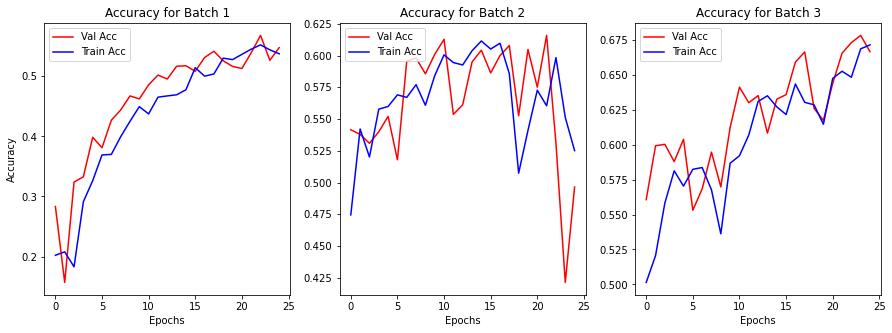

In [14]:
def visualise_train_hist(hist_dict, metric="acc"):
    if metric == "loss":
        y_lbl = "Loss"
        titl = "Loss"
        
        train_met = "loss"
        train_lbl = "Train Loss"
        
        val_met = "val_loss"
        val_lbl = "Val Loss"
    else:
        y_lbl = "Accuracy"
        titl = "Accuracy"
        
        train_met = "accuracy"
        train_lbl = "Train Acc"
        
        val_met = "val_accuracy"
        val_lbl = "Val Acc"
        
        
    batch_0_hist = hist_dict[0]
    batch_1_hist = hist_dict[1]
    batch_2_hist = hist_dict[2]
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    
    axs[0].plot(batch_0_hist.epoch,batch_0_hist.history[val_met], color="red", label = val_lbl)
    axs[0].plot(batch_0_hist.epoch,batch_0_hist.history[train_met], color="blue", label = train_lbl)
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel(y_lbl)
    axs[0].set_title(titl + ' for Batch 1')
    axs[0].legend(loc='upper left')
    
    axs[1].plot(batch_1_hist.epoch,batch_1_hist.history[val_met], color="red", label = val_lbl)
    axs[1].plot(batch_1_hist.epoch,batch_1_hist.history[train_met], color="blue", label = train_lbl)
    axs[1].set_xlabel('Epochs')
    axs[1].set_title(titl + ' for Batch 2')
    axs[1].legend(loc='upper left')
    
    axs[2].plot(batch_2_hist.epoch,batch_2_hist.history[val_met], color="red", label = "Val Acc")
    axs[2].plot(batch_2_hist.epoch,batch_2_hist.history[train_met], color="blue", label = train_lbl)
    axs[2].set_xlabel('Epochs')
    axs[2].set_title(titl + ' for Batch 3')
    axs[2].legend(loc='upper left')

visualise_train_hist(train_hist) # , metric="loss"

## Prediction

In [17]:
model

### Test data

Setting the path to test images. `test_y_loc` is the location where the predicted outputs should be saved.

In [15]:
test_x_loc = "../data/test_images/"
test_y_loc = "../data/test_preds/"

Extract the names of the test images and sort them and store them in a list.

In [16]:
test_img_names = sorted([s[:-4] for s in os.listdir(test_x_loc)])

In [17]:
print("Number of test images = ", len(test_img_names))

Number of test images =  112


### Ready the model

If `USE_CURRENT_MODEL` is False, then provide the location of the saved model you want to use in `SAVED_MODEL_LOC`.

In [28]:
USE_CURRENT_MODEL = False
SAVED_MODEL_LOC = TRAINING_SAVE_LOC + "batch_0/"

In [29]:
if not USE_CURRENT_MODEL:
    model = tf.keras.models.load_model(SAVED_MODEL_LOC)
    print("Model loaded from ", SAVED_MODEL_LOC)

Model loaded from  saved_models/training_20/batch_0/


### Predict the output and save the mask as .png file

In [ ]:
def get_predictions(image_loc, test_img_names):
    y_test = {}
    print("Predicting for {} images".format(len(test_img_names)))
    for i in test_img_names:
        print("Predicting for img",i)
        x_test = np.array(PIL.Image.open(image_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255 #
        x_test = x_test.reshape((1,512,512,3))
        y_test[i] = model.predict(x_test, verbose=1)
        del x_test
    return y_test

def create_mask(image_dict):
    y_test_mask = {}
    print("Creating masks for {} predictions".format(len(image_dict)))
    for name, img in image_dict.items():
        pred_mask = tf.argmax(img, axis=3)
        pred_mask= np.uint8(pred_mask[0].numpy())
        y_test_mask[name] = pred_mask
    return y_test_mask
        
def save_mask(mask_dict):
    for name, mask in mask_dict.items():
        im = PIL.Image.fromarray(mask)
        im.save(test_y_loc + name + '.png')
        print("Image saved: ", test_y_loc + name + '.png')

preds = get_predictions(test_x_loc,test_img_names)
masks = create_mask(preds)
save_mask(masks)



### Saving the output for kaggle submission

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles(test_pred_dir):
    """Used for Kaggle submission: predicts and encode all test images"""
    N = len([i for i in list(os.listdir(test_pred_dir)) if i[-3:] == "png"])
    with open('submissions/submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(test_pred_dir)):
            if i[-3:] == "png":
                print('Saving {}/{}'.format(index, N))
                mask = PIL.Image.open(test_pred_dir + i)
                mask = mask.resize((1024, 1024), resample= PIL.Image.NEAREST)
                mask = np.array(mask)

                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles(test_y_loc) 

## Making a kaggle submission

Make sure you have installed the kaggle package and completed all the steps listed here : https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953

In [ ]:
# Update the below code to make the submission to a kaggle submission
# !kaggle competitions submit -c 

## Visualise the output of the model prediction

Predicting for 1 images
Predicting for img 6456
1/1 [==============================] - 0s 11ms/step
Creating masks for 1 predictions
dict_keys(['6456'])


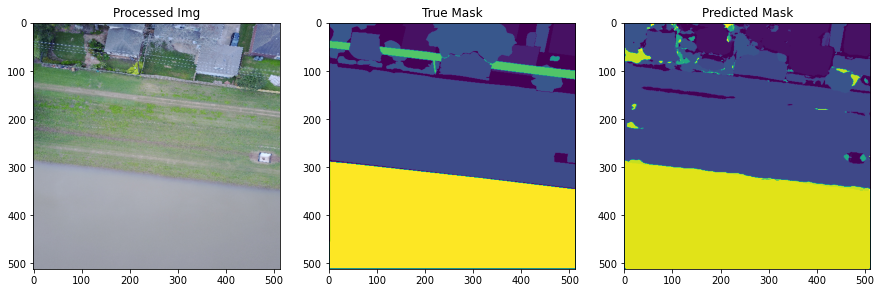

In [30]:
def visualise_test(image_name):

    img1 = np.array(PIL.Image.open(test_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    img2 = mpimg.imread(test_y_loc + image_name +'.png')

    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('Predicted img')
    
def visualise_train(image_name):

    img1 = np.array(PIL.Image.open(train_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    img2 = np.array(PIL.Image.open(train_y_loc + image_name + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))

    img_name = [image_name]
    pred = get_predictions(train_x_loc,img_name)
    mask = create_mask(pred)
    print(mask.keys())
    img3 = mask[image_name]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('True Mask')
    axs[2].imshow(img3)
    axs[2].set_title('Predicted Mask')
    
assert(model is not None)
# visualise_test('') # provide only image names from 'train_images'
visualise_train('6456') # provide only image names from 'test_images'